<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/meta_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/google/jax-md

import time 

from functools import partial
import numpy as onp

import jax.numpy as np

from jax import jit
from jax import grad
from jax import vmap

from jax import random
from jax import lax

from jax.experimental import stax
from jax.experimental import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import quantity
from jax_md.util import f32, f64


# Progress Bars.
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# Matplotlib settings.

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_system(R, box_size, marker_size, color=None):
  if color == None:
    color = [64 / 256] * 3
  ms = marker_size / box_size

  R = onp.array(R)

  marker_style = dict(
      linestyle='none', 
      markeredgewidth=3,
      marker='o', 
      markersize=ms, 
      color=color, 
      fillstyle='none')

  plt.plot(R[:, 0], R[:, 1], **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.axis('off')
  plt.gca().set_facecolor([1, 1, 1])


# System property utilities.

def box_size_at_number_density(particle_count, number_density):
  return f32((particle_count / number_density) ** 0.5)

## Optimization Through Dynamics

Combining molecular dynamics with automatic differentiation opens the door for qualitatively new research. One such avenue involves differentiating through the simulation trajectory to optimize physical parameters. There have been several excellent applications so far in e.g. [protein folding](https://openreview.net/forum?id=Byg3y3C9Km), but until now this has involved significant amounts of specialized code. This vein of research is also similar to recent work in machine learning on [meta-optimization.](https://arxiv.org/abs/1606.04474) 

As an example we will perform optimize the parameters of a simple system to show that one can optimize for particular structural characteristics. In particular, we will imagine bubbles floating on water so that the bubbles live on a two-dimensional interface between water and air. It turns out that if the bubbles all have the same size and they are compressed then they form a crystal. Here's an example of a real experiment from [Wikipedia](https://en.wikipedia.org/wiki/Bubble_raft):

![alt text](https://upload.wikimedia.org/wikipedia/commons/8/89/Bubblerraft2.jpg)

However, if the bubbles have have different sizes, the crystal order breaks down and the system becomes random.

<img src="https://physicstoday.scitation.org/action/showOpenGraphArticleImage?doi=10.1063/PT.3.4243&id=images/medium/pt.3.4243.figures.online.pt.3.4243highlight.jpg" width="400">

We will show how one can control the structure of the bubble raft by differentiating through the simulation to tune how homogeneous or inhomogeneous the bubble sizes are. To experiment with these changes, we're going to set up a simulation of a bubble raft with bubbles of two distinct sizes. To keep things simple, we'll let half of the bubbles have diameter $1$ and half have diameter $D$. 

To control the conditions of the experiment, we will keep the total volume of the bubbles constant. To do this, note that if there are $N$ bubbles then the total volume of water filled by bubbles is,
$$V_{\text{bubbles}} = \frac N8\pi(D^2 + 1)$$
where the factor of $8$ comes from the fact that our system is split into two halves and we are using diameters not radii. Since the volume of our simulation is $V = L^2$ if we want to keep the "packing fraction", $\phi = V_{\text{bubbles}} / V$ constant then we will have to scale the size of the box to be,
$$L = \sqrt{\frac{V_{\text{bubbles}}}{\phi}}.$$
We begin by setting up some experiment parameters and writing a function to compute $L$ as a function of $D$.

In [2]:
N = 128
N_2 = N // 2

simulation_steps = np.arange(300)
dt = 1e-2
temperature = 1e-5

key = random.PRNGKey(0)

packing_fraction = 0.98
markersize = 260

def box_size_at_packing_fraction(diameter):
  bubble_volume = N_2 * np.pi * (diameter ** 2 + 1) / 4
  return np.sqrt(bubble_volume / packing_fraction)

Next we need to posit interactions between our model bubbles. We'll assume that we can model a pair of bubbles by defining an energy function for the pair. We use an energy that is zero if the bubbles are not touching and increases gradually as they get pushed together. Specifically, we will consider two bubbles, $i$ and $j$, with radii $\sigma_i$ and $\sigma_j$ respectively. If $r_{ij}$ is the distance between the bubbles, we'll posit a function that looks like:

$$
U(r_{ij}) = \begin{cases}
  \left(1 - \frac{r_{ij}}{\sigma_{ij}}\right)^2 & \text{if $r_{ij} < \sigma_{ij}$} \\ 
  0 & \text{if $r_{ij}>\sigma_{ij}$}
  \end{cases}
$$  
where $\sigma_{ij} = \sigma_i + \sigma_j$. When we run our simulation, by having bubbles move to try to minimize the energy between them they will naturally separate if they overlap.

This is implemented in JAX MD using the function `energy.soft_sphere(r, sigma)` which takes a distance and returns an energy.

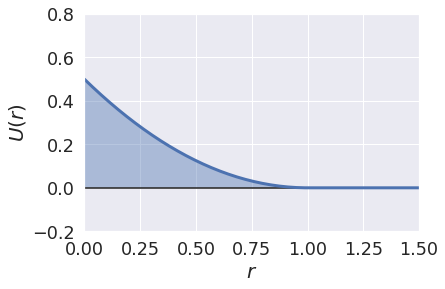

In [3]:
plt.gca().axhline(y=0, color='k')
plt.xlim([0, 1.5])
plt.ylim([-0.2, 0.8])

dr = np.linspace(0, 3.0, num=80)
plt.plot(dr, energy.soft_sphere(dr, sigma=1), 'b-', linewidth=3)
plt.fill_between(dr, energy.soft_sphere(dr), alpha=0.4)

format_plot('$r$', '$U(r)$')

Once we've assigned an energy, $U(r_{ij}, \sigma_{ij})$, to pairs of bubbles, we have to assign an energy to to the whole system, $\mathcal U$. As we will see, our simulation will make use of the forces, $\vec F_i = -\nabla_{\vec r_i}\mathcal U$. This is usually done by just summing up all the pairwise energies,
$$\mathcal U = \frac12\sum_{ij}U(r_{ij}, \sigma_{ij}).$$
Since we only have two different particle diameters, it is efficient to partition our system into bubbles of different "species" labelled "A" and "B". Since we have two different species this gives us three different $\sigma$ to define: $\sigma_{AA}$, $\sigma_{AB}$, and $\sigma_{BB}$. We know that $\sigma_{AA} = D$ and $\sigma_{BB} = 1$, but what should $\sigma_{AB}$ be? Since the $\sigma$ denote radii, it should be the case that $\sigma_{AB} = \frac12(D + 1)$. We can setup a helper function to setup the species now. 


In [4]:
species = np.array([0] * (N_2) + [1] * (N_2), dtype=np.int32)

def species_sigma(diameter):
  d_AA = diameter
  d_BB = 1
  d_AB = 0.5 * (diameter + 1)
  return np.array(
      [[d_AA, d_AB], 
       [d_AB, d_BB]]
  )

To compute the energy of the whole bubble raft in JAX, M.D. we use the helper function `energy_fun = energy.soft_sphere_pair` which returns a function that computes the soft-sphere energy for our bubble raft in its periodic box. We will feed the `species` and `sigma` definitions into the `energy.soft_sphere_pair` function. 

We will use this to write a simulation that takes a diameter and a random key, randomly instantiates the system, and then minimizes the system to its nearest energy minimum. We will have our simulation return the size of the box, the final state, and the energy of the state. To do this we will use the minimizer, `minimize.fire_descent` provided by JAX MD. 

In [5]:
@jit
def simulation(diameter, key):
  # Create the simulation environment.
  box_size = box_size_at_packing_fraction(diameter)
  displacement, shift = space.periodic(box_size)

  # Create the energy function.
  sigma = species_sigma(diameter)
  energy_fun = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  # Randomly initialize the system.
  R = random.uniform(key, (N, 2), maxval=box_size)

  # Minimize to the nearest minimum.
  init_fn, apply_fn = minimize.fire_descent(energy_fun, shift)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fun(state.position), state.position

Now let's run simulations with two different values of $D$ and draw them side-by-side. In one case we will use $D = 1$ so that both species are the same and this will result in the same hexagonal configuration as in the warm up. However, we will then run a simulation with $D = 0.8$ to see what happens when all the bubbles don't have the same size.

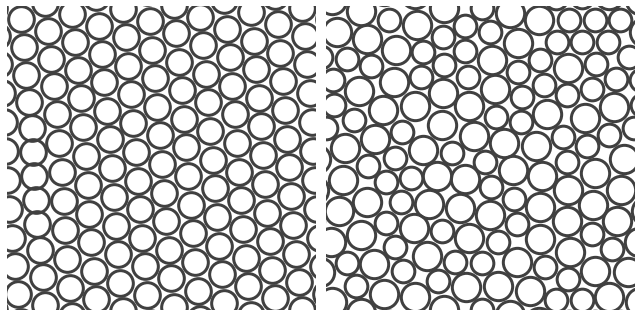

In [6]:
plt.subplot(1, 2, 1)

box_size, raft_energy, bubble_positions = simulation(1.0, key)
draw_system(bubble_positions, box_size, markersize)
finalize_plot((0.5, 0.5))

plt.subplot(1, 2, 2)

box_size, raft_energy, bubble_positions = simulation(0.8, key)
draw_system(bubble_positions[:N_2], box_size, 0.8 * markersize)
draw_system(bubble_positions[N_2:], box_size, markersize)
finalize_plot((2.0, 1))

The hexagonal structure when the bubbles have the same size has broken down in the two-species case. To get a bit more insight into this we will use JAX's automatic vectorization capabilities (via `vmap`) to see how the structure and energy of bubble rafts depends on `diameter`.

In [7]:
ensemble_size = 40

# Vectorize over both random keys and diameter.
vec_simulation = vmap(vmap(simulation, (None, 0)), (0, None))

sim_keys = random.split(key, ensemble_size)
diameter = np.linspace(0.4, 1.0, 10)

box_size, raft_energy, bubble_positions = vec_simulation(diameter, sim_keys)

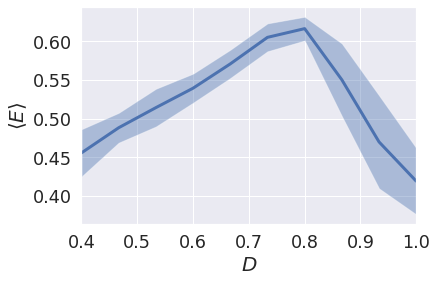

In [8]:
E_mean = np.mean(raft_energy, axis=1)
E_std = np.std(raft_energy, axis=1)

plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

At small values of the diameter, the energy is low and increases with increasing diameter until a maximum in the energy at which point it drops precipitously. We can visualize an example system at each of these diameter disparities to see what is happening. We will color the bubble rafts by their energy.

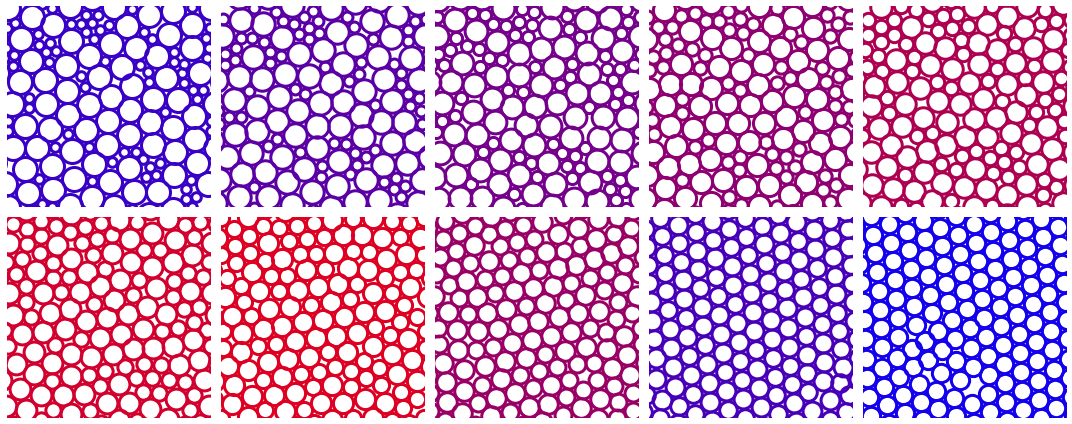

In [9]:
ms = 185
for i, d in enumerate(diameter):
  plt.subplot(2, 5, i + 1)
  c = min(1, max(0, (E_mean[i] - 0.4) * 4))
  color = [c, 0, 1 - c] 
  draw_system(bubble_positions[i, 0, :N_2], box_size[i, 0], d * ms, color=color)
  draw_system(bubble_positions[i, 0, N_2:], box_size[i, 0], ms, color=color)

finalize_plot((2.5, 1))

When the diameter of the small bubbles is close to the diamater of the large bubbles the structure is close to hexagonal. Likewise, when the small bubble diameter is very small, the small bubbles fit into the interstices and regions retain the hexagonal order.  However, when the diameter is in-between (where the energy is high) the bubbles end up looking like they are arranged randomly. This is an effect known as the [Jamming transition.](https://en.wikipedia.org/wiki/Jamming_(physics)) However, could we have found this optimally disordered region without brute force? Let's try to maximize the energy with respect to the diameter, $D$, directly. 

To do this, we will run short simulation trajectories starting with the positions after minimization that we found above. At the end of the short simulation we will compute the energy of the bubble raft. We will take the derivative of the energy after the short simulation with respect to the particle diameter.  To do this we will make use of the JAX's `grad` function. The function `df_dx = grad(f)` takes a function and returns a new function that computes its gradient with respect to its first argument. 

One subtlety that is involved in writing this simulation is the use of periodic boundary conditions. Periodic boundary conditions incorporate the box size in the form of a modulus `dR_periodic = np.mod(dR, box_size)`. However, the modulus is not differentiable in its second argument and so information is lost. To ensure that gradients properly flow through the box shape, we must use `space.periodic_general` instead. `space.periodic_general` allows us to define points in a deforming box.

In [10]:
short_simulation_steps = np.arange(10)
def short_simulation(diameter, positions, key):
  L = box_size_at_packing_fraction(diameter)
  displacement, shift = space.periodic_general(L * np.eye(2), 
                                               fractional_coordinates=False)

  sigma = species_sigma(diameter)
  energy_fun = energy.soft_sphere_pair(displacement, species, sigma)

  init_fn, apply_fn = minimize.gradient_descent(energy_fun, shift, 1e-3)
  state = init_fn(positions)

  do_step = lambda state, t: (apply_fn(state), ())
  state, _ = lax.scan(do_step, state, short_simulation_steps)

  return energy_fun(state)

Next, let's take the derivative of the energy with respect to the particle diameters and vectorize it over the ensemble of initial positions.


In [11]:
dE_dD_fun = grad(short_simulation)
dE_dD_fun = jit(vmap(dE_dD_fun, (None, 0, 0)))

Now, we run the simulation for each diameter and record the gradients over each member of the ensemble. We then plot the average gradient against diameter and compare it with the energy that we found by directly simulating the bubble raft.

In [12]:
dE_dD = []
for i, d in ProgressIter(enumerate(diameter), len(diameter)):
  key, split = random.split(key)
  split = random.split(split, ensemble_size)
  dE_dD += [dE_dD_fun(d, bubble_positions[i], split)]
dE_dD = np.array(dE_dD)

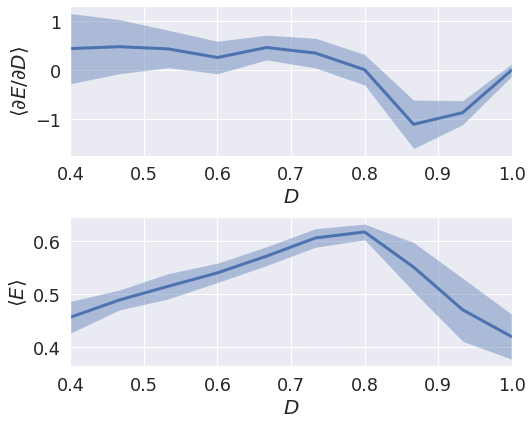

In [13]:
plt.subplot(2, 1, 1)

dE_mean = np.mean(dE_dD, axis=1)
dE_std = np.std(dE_dD, axis=1)

plt.plot(diameter, dE_mean, linewidth=3)
plt.fill_between(diameter, dE_mean + dE_std, dE_mean - dE_std, alpha=0.4)

plt.xlim([0.4, 1.0])
format_plot('$D$', '$\\langle \\partial E/\\partial D\\rangle$')

plt.subplot(2, 1, 2)
plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

finalize_plot((1.25, 1))

We see that the gradient is positive and constant for $D < 0.8$ corresponding to the linear increase in the average energy. Moreover, we see that the derivative crosses zero exactly at the maximum average energy. Finally, we observe that the gradient goes back to zero at $D = 1$. This suggests that $D = 0.8$ is the point of maximum disorder, as we found by brute force above. It also shows that $D = 1$ is the minimum energy configuration of the diameter. Although we hadn't hypothesized it, we realize this must be true since $D < 1$ states are symmetric with $D > 1$ as we keep the total packing fraction constant.

This example demonstrates that meaningful insight and optimization efficiency can arise when automatic differentiation is paired with simulation. However, it also highlights a potential pitfall of these approaches: it is critically important to think about the parameterization of the problem when thinking about taking gradients through physical simulations.